## Import 

In [1]:
import cv2
import time
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mmdet.apis import inference_detector, init_detector
from mmpose.apis import inference_topdown, init_model as init_pose_estimator
from mmpose.structures import merge_data_samples
from mmpose.evaluation.functional import nms
from mmengine.registry import init_default_scope
from mmpose.registry import VISUALIZERS
import mmcv
from mmpose.utils import adapt_mmdet_pipeline

## Inferencer and Model

Device and image

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device : ", device)

Device :  cuda


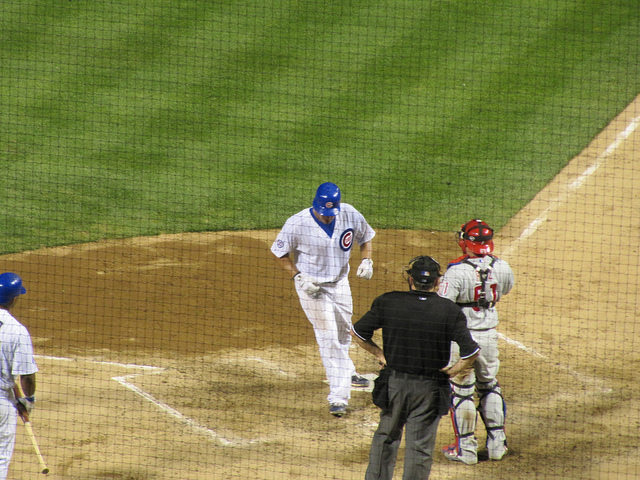

In [4]:
img_path = "../../Data/Squat/000000000192.jpg"
img_pil = Image.open(img_path)
img = np.array(img_pil)
img_pil

Build Detector and Estimator

In [5]:
# model to use
pose_config = '../../mmpose/projects/rtmpose/rtmpose/body_2d_keypoint/rtmpose-m_8xb256-420e_coco-256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-aic-coco_pt-aic-coco_420e-256x192-63eb25f7_20230126.pth'

det_config='../../mmpose/projects/rtmpose/rtmdet/person/rtmdet_nano_320-8xb32_coco-person.py'
det_checkpoint = 'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth'

In [6]:
# build detector
detector = init_detector(det_config, det_checkpoint, device=device)
detector.cfg = adapt_mmdet_pipeline(detector.cfg)

# build pose estimator
pose_estimator = init_pose_estimator(pose_config, pose_checkpoint, device=device)

# build visualizer
pose_estimator.cfg.visualizer.radius = 3
pose_estimator.cfg.visualizer.alpha = 0.8
pose_estimator.cfg.visualizer.line_width = 1
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_pose_estimator
visualizer.set_dataset_meta(
    pose_estimator.dataset_meta, skeleton_style='mmpose')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-aic-coco_pt-aic-coco_420e-256x192-63eb25f7_20230126.pth
07/21 15:50:42 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [7]:
def process_one_image(img,
                      detector,
                      pose_estimator,
                      visualizer=None,
                      show_interval=0):
    """Visualize predicted keypoints (and heatmaps) of one image."""

    # predict bbox
    det_result = inference_detector(detector, img)
    pred_instance = det_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate(
        (pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    bboxes = bboxes[np.logical_and(pred_instance.labels == 0,
                                   pred_instance.scores > 0.3)]
    bboxes = bboxes[nms(bboxes, 0.3), :4]
    print(bboxes)

    # predict keypoints
    pose_results = inference_topdown(pose_estimator, img, bboxes)
    data_samples = merge_data_samples(pose_results)

    # show the results
    if isinstance(img, str):
        img = mmcv.imread(img, channel_order='rgb')
    elif isinstance(img, np.ndarray):
        img = mmcv.bgr2rgb(img)

    if visualizer is not None:
        visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=False,
            draw_bbox=True,
            show_kpt_idx=False,
            skeleton_style='mmpose',
            show=False,
            wait_time=show_interval,
            kpt_thr=0.3)

    # if there is no instance detected, return None
    return data_samples.get('pred_instances', None)

Test on image

/home/trousseaux/PoseEstimation/posespotterpro/mmposevenv/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[[2.7108221e+02 1.8109856e+02 3.7597449e+02 4.1970325e+02]
 [3.5426114e+02 2.5443712e+02 4.7892780e+02 4.8030655e+02]
 [2.8076172e-03 2.6949802e+02 3.8180328e+01 4.7878711e+02]
 [4.3600336e+02 2.1837569e+02 5.1662756e+02 4.6380719e+02]]


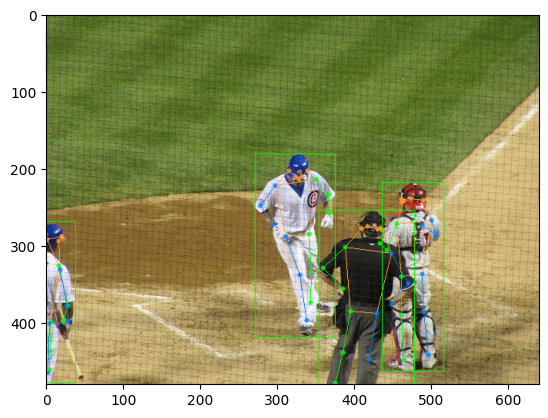

In [8]:
preds = process_one_image(img, detector, pose_estimator, visualizer, show_interval=0)
img_output = visualizer.get_image()
# Convert BGR to RGB
img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)
plt.imshow(img_output)

In [8]:
preds[0]

<InstanceData(

    META INFORMATION

    DATA FIELDS
    bbox_scores: array([1.], dtype=float32)
    keypoint_scores: array([[1.0510557 , 0.96939075, 1.0745518 , 0.584791  , 1.030975  ,
                0.854064  , 0.77463   , 0.88996184, 0.8783412 , 0.81270164,
                0.8094964 , 0.747254  , 0.7168928 , 0.919523  , 0.7594569 ,
                0.8997788 , 0.8702853 ]], dtype=float32)
    keypoints: array([[[278.08273156, 148.66550052],
                [276.3310105 , 140.78275537],
                [270.19998678, 140.78275537],
                [264.94482358, 147.78963995],
                [245.67589188, 146.91377938],
                [259.68966039, 196.83783197],
                [206.26216793, 195.9619714 ],
                [249.179334  , 252.017048  ],
                [199.25528367, 270.41012001],
                [278.9585921 , 294.05835545],
                [259.68966039, 299.31351888],
                [213.26905219, 299.31351888],
                [170.35188611, 294.93421602],

## Live Webcam Feed

In [9]:
cap = cv2.VideoCapture(0)  # capture from camera

resolution = cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
num_frames = 0
start_time = time.time()

while True:
    ret, frame = cap.read() # read frame by frame

    if not ret: # if frame is read correctly ret is True
        print("Impossible de recevoir le cadre (flux vidé). Sortie ...")
        break

    try:
        # topdown pose estimation
        pred_instances = process_one_image(frame, detector,
                                            pose_estimator, visualizer,
                                            0.000)
        img_output = visualizer.get_image()
        img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)
    except:
        print("Fail")

    num_frames += 1
    fps = num_frames / (time.time() - start_time)
    height, width, _ = frame.shape

    # Add text
    size_text = 0.5
    cv2.putText(img_output, f"FPS: {fps:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, size_text, (255, 0, 0))
    cv2.putText(img_output, f"Dimensions: {width}x{height}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, size_text, (255, 0, 0))
    cv2.putText(img_output, f"Resolution: {resolution[0]}x{resolution[1]}", (10, 90), cv2.FONT_HERSHEY_SIMPLEX, size_text, (255, 0, 0))

    cv2.imshow('Webcam', img_output) # Display the resulting frame

    if cv2.waitKey(1) == ord('q'): # Press q to quit
        break

cap.release()
cv2.destroyAllWindows()
